# Reparameterize force fields


The `ForceFieldGenerator` class in `VeloxChem` provides a number of functions to interact with `OpenMM` and manipulate topology files. As an example, we consider the optimization of the force field for two dihedral angles of a thiophene-based optical ligand named HS-276.


## Dihedral angles

We here consider two dihedral angles, $\phi_1$ and $\phi_2$:

```{figure} ../../img/md/hs276.png
---
width: 600px
name: fig_hs
---
```

The dihedral potential curves will be plotted using force field parameters from the general amber forcefield (GAFF) database, as compared to QM results. The force field will then be changed to better fit this potential.

Load the required modules and the equilibrium geometry, and initialize a force field generator object:

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx
import py3Dmol as p3d
from pathlib import Path

# load B3LYP optimized geometry in the xyz format
molecule = vlx.Molecule.read_xyz_file("../../data/md/hs276.xyz")

ff_gen = vlx.ForceFieldGenerator()

The QM scans of the two dihedrals is read by the `ff_gen` object:

In [ ]:
ff_gen.read_qm_scan_xyz_files(['../../data/md/1_14_15_16.xyz',
                               '../../data/md/27_22_21_16.xyz'])

The optimized structure and the two scans is visualized as:

In [30]:
with open('../../data/md/1_14_15_16.xyz', 'r') as fh:
    dihedral1_xyzs = fh.read()

with open('../../data/md/27_22_21_16.xyz', 'r') as fh:
    dihedral2_xyzs = fh.read()

print('Optimized structure:')
viewer = p3d.view(width=400,height=250)
viewer.addModel(molecule.get_xyz_string(), 'xyz')
viewer.setStyle({'stick': {}})
viewer.zoomTo()
viewer.show()

print(u'Rotation around \u03C6\u2081 and \u03C6\u2082:')
viewer = p3d.view(viewergrid=(1,2),width=600,height=250, linked=False)
viewer.addModelsAsFrames(dihedral1_xyzs, viewer=(0,0))
viewer.animate({"loop": "BackAndForth"}, viewer=(0,0))
viewer.addModelsAsFrames(dihedral2_xyzs, viewer=(0,1))
viewer.animate({"loop": "BackAndForth"}, viewer=(0,1))
viewer.setStyle({'stick': {}})
viewer.zoomTo()
viewer.show()

Optimized structure:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Rotation around φ₁ and φ₂:


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Furthermore, [RESP charges](../env/resp) are provided:

In [31]:
resp_chg = [
    0.014967, 0.224409, 0.089489, -0.551618, 0.153050, 0.106847, -0.315042,
    0.165854, 0.206441, -0.425163, 0.225816, -0.039099, 0.179377, 0.002119,
    0.014483, -0.043666, -0.230202, 0.165960, -0.071404, 0.188598, -0.044661,
    0.088786, -0.173586, 0.175730, -0.089376, 0.164515, -0.118573, -0.150541,
    0.736497, -0.570770, -0.273724, -0.144051, 0.112846, 0.112846, 0.112846
]

Finally, we identify atom types and generate initial force field files:

In [32]:
atomtypeidentifier = vlx.AtomTypeIdentifier()
atom_types = atomtypeidentifier.generate_gaff_atomtypes(molecule)

ff_gen.molecule_name = 'hs276'
ff_gen.molecule = molecule
ff_gen.atom_types = atom_types
ff_gen.force_field_data = '../../data/md/gaff-2.11.dat'
ff_gen.force_field_data_extension = '../../data/md/gaff-2.11_extension.dat'

ff_gen.workdir = Path('../../data/md')
ff_gen.workdir.mkdir(parents=True, exist_ok=True)

original_itp_file = ff_gen.workdir / (ff_gen.molecule_name + f'_{ff_gen.ffversion:02d}.itp')
original_top_file = original_itp_file.with_suffix('.top')

ff_gen.write_original_itp(original_itp_file, atom_types, resp_chg)
ff_gen.write_top(original_top_file, original_itp_file)

* Info * Updated bond length 10-12 (cd-cd) to 0.137 nm                                                                    
* Info * Updated bond angle 1-9-10 (ca-ca-cd) to 107.2 deg                                                                
* Info * Updated bond angle 1-14-15 (ca-na-cc) to 126.6 deg                                                               
* Info * Updated bond angle 2-1-14 (ca-ca-na) to 131.7 deg                                                                
* Info * Updated bond angle 7-9-10 (ca-ca-cd) to 135.3 deg                                                                
* Info * Updated bond angle 9-1-14 (ca-ca-na) to 107.6 deg                                                                
* Info * Updated bond angle 14-15-17 (na-cc-cd) to 128.3 deg                                                              
* Info * Updated bond angle 19-21-22 (cd-cc-cc) to 129.2 deg                                                              
* Info * Updated

## GAFF force field

The performance of the original GAFF force field is evaluated by calculating the energy at each dihedral angle from the scan:

```python
phi_results = []
for i in range(len(ff_gen.target_dihedrals)):
    result = ff_gen.validate_force_field(original_top_file, i)
    phi_results.append(result)
```

*Note:* These calculations are not executed in the compilation of the book, and the results are instead loaded below.

In [33]:
phi_results = [{
    'dihedral_indices': [1, 14, 15, 16],
    'dihedral_angles': [
        0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0,
        120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0
    ],
    'mm_scan_kJpermol': np.array([
        0.39044189, 0.48483276, 1.27550507, 3.36181641, 6.98594666, 12.12945557,
        18.5289917, 25.62785339, 32.54138184, 37.5798645, 31.9957428,
        25.07746887, 17.94574738, 11.35903931, 5.9148407, 2.06106567,
        0.07492065, 0., 1.5214386
    ]),
    'qm_scan_kJpermol': np.array([
        7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375, 1.14209234,
        1.24448683, 1.88248324, 2.57298965, 2.70951563, 2.2185472, 1.34950681,
        0.50672143, 0., 0.13652598, 1.11846285, 2.99044409, 5.39540176,
        6.79216757
    ])
}, {
    'dihedral_indices': [27, 22, 21, 16],
    'dihedral_angles': [
        0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0,
        120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0
    ],
    'mm_scan_kJpermol': np.array([
        6.73690796, 8.89929199, 15.06036377, 24.88541412, 37.83436584,
        53.18778992, 70.07821655, 87.53006744, 104.49455261, 115.61375427,
        99.45341492, 81.94953918, 64.11863708, 46.92655945, 31.30844116,
        18.13588715, 8.1687088, 1.99819183, 0.
    ]),
    'qm_scan_kJpermol': np.array([
        3.83585497, 3.39214553, 3.07446008, 3.05870708, 3.79647248, 5.41640576,
        7.76097693, 10.36547258, 12.46062129, 13.21413969, 12.26370882,
        9.96902213, 7.13610802, 4.45022189, 2.31569068, 0.94255437, 0.29405596,
        0.08664149, 0.
    ])
}]

fitted_phi_results = [{
    'dihedral_indices': [1, 14, 15, 16],
    'dihedral_angles': [
        0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0,
        120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0
    ],
    'mm_scan_kJpermol': np.array([
        8.85865021, 6.5467453, 3.92016602, 2.18968964, 1.42712402, 1.39407349,
        1.69501495, 1.93608093, 1.92350769, 1.69535828, 1.40233612, 1.13204956,
        0.84503174, 0.46120453, 0.05204773, 0., 0.96090698, 3.59947205,
        9.49703217
    ]),
    'qm_scan_kJpermol': np.array([
        7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375, 1.14209234,
        1.24448683, 1.88248324, 2.57298965, 2.70951563, 2.2185472, 1.34950681,
        0.50672143, 0., 0.13652598, 1.11846285, 2.99044409, 5.39540176,
        6.79216757
    ])
}, {
    'dihedral_indices': [27, 22, 21, 16],
    'dihedral_angles': [
        0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0,
        120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0
    ],
    'mm_scan_kJpermol': np.array([
        3.77013397, 3.43408203, 2.92618561, 2.82312012, 3.59525299, 5.37159729,
        7.85509491, 10.40908813, 12.28764343, 12.91279602, 12.07723999,
        10.00006104, 7.22518921, 4.41876221, 2.14795685, 0.7151413, 0.09519958,
        0., 0.07654572
    ]),
    'qm_scan_kJpermol': np.array([
        3.83585497, 3.39214553, 3.07446008, 3.05870708, 3.79647248, 5.41640576,
        7.76097693, 10.36547258, 12.46062129, 13.21413969, 12.26370882,
        9.96902213, 7.13610802, 4.45022189, 2.31569068, 0.94255437, 0.29405596,
        0.08664149, 0.
    ])
}]

improved_phi_results = [{
    'dihedral_indices': [1, 14, 15, 16],
    'dihedral_angles': [
        0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0,
        120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0
    ],
    'mm_scan_kJpermol': np.array([
        9.39545441, 7.01393127, 4.20561218, 2.25416565, 1.3174057, 1.2179184,
        1.57676697, 1.96492004, 2.10110474, 1.94235229, 1.59909821, 1.18383789,
        0.74294281, 0.30089569, 0., 0.21685028, 1.52063751, 4.42159271,
        10.43003845
    ]),
    'qm_scan_kJpermol': np.array([
        7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375, 1.14209234,
        1.24448683, 1.88248324, 2.57298965, 2.70951563, 2.2185472, 1.34950681,
        0.50672143, 0., 0.13652598, 1.11846285, 2.99044409, 5.39540176,
        6.79216757
    ])
}, {
    'dihedral_indices': [27, 22, 21, 16],
    'dihedral_angles': [
        0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0,
        120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0
    ],
    'mm_scan_kJpermol': np.array([
        3.7759552, 3.45406342, 2.97280884, 2.90036011, 3.69313049, 5.46485138,
        7.9087677, 10.39290619, 12.19385529, 12.76613617, 11.92942047,
        9.90858459, 7.22563934, 4.50617981, 2.2787323, 0.83068085, 0.15373993,
        0., 0.05529785
    ]),
    'qm_scan_kJpermol': np.array([
        3.83585497, 3.39214553, 3.07446008, 3.05870708, 3.79647248, 5.41640576,
        7.76097693, 10.36547258, 12.46062129, 13.21413969, 12.26370882,
        9.96902213, 7.13610802, 4.45022189, 2.31569068, 0.94255437, 0.29405596,
        0.08664149, 0.
    ])
}]

improved_phi_results_new = [{
    'dihedral_indices': [1, 14, 15, 16],
    'dihedral_angles': [
        20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0,
        130.0, 140.0, 150.0, 160.0, 170.0
    ],
    'mm_scan_kJpermol': np.array([
        5.42739868, 2.89348602, 1.45018768, 1.0739975, 1.42835999, 2.00170898,
        2.36753082, 2.33047485, 1.92477417, 1.30165863, 0.63945007, 0.1234436,
        0., 0.6337204, 2.46183014, 5.81786346
    ]),
    'qm_scan_kJpermol': np.array([
        5.23524628, 3.25299405, 1.80634375, 1.14209234, 1.24448683, 1.88248324,
        2.57298965, 2.70951563, 2.2185472, 1.34950681, 0.50672143, 0.,
        0.13652598, 1.11846285, 2.99044409, 5.39540176
    ])
}, {
    'dihedral_indices': [27, 22, 21, 16],
    'dihedral_angles': [
        0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0,
        120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0
    ],
    'mm_scan_kJpermol': np.array([
        3.76613617, 3.44065094, 2.93300629, 2.82655334, 3.59573364, 5.37197876,
        7.85752106, 10.41316223, 12.29174805, 12.91529846, 12.07827759,
        10.00108337, 7.22787476, 4.42301941, 2.15213776, 0.71668243, 0.0941925,
        0., 0.08368683
    ]),
    'qm_scan_kJpermol': np.array([
        3.83585497, 3.39214553, 3.07446008, 3.05870708, 3.79647248, 5.41640576,
        7.76097693, 10.36547258, 12.46062129, 13.21413969, 12.26370882,
        9.96902213, 7.13610802, 4.45022189, 2.31569068, 0.94255437, 0.29405596,
        0.08664149, 0.
    ])
}]

The resulting potentials can be visualized as:

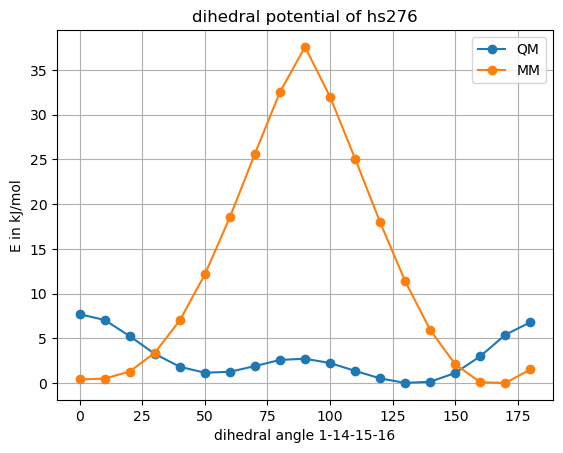

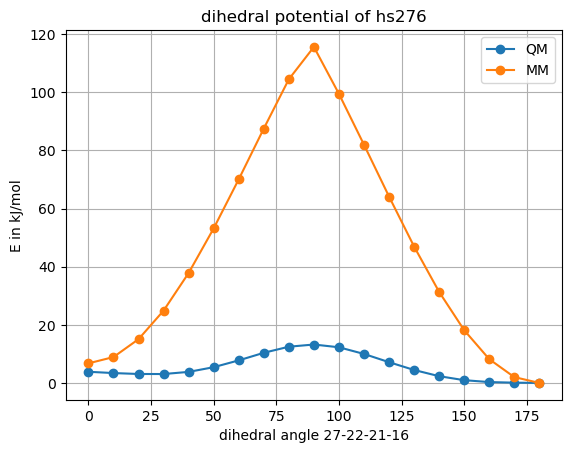

In [34]:
ff_gen.visualize(phi_results[0])
ff_gen.visualize(phi_results[1])

Alternatively, we can construct custom plotting scripts by first checking the contents of the results dictionaries:

In [35]:
print(phi_results[0])

{'dihedral_indices': [1, 14, 15, 16], 'dihedral_angles': [0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0], 'mm_scan_kJpermol': array([ 0.38636858,  0.48247293,  1.27570957,  3.36342458,  6.98809449,
       12.13142224, 18.5303525 , 25.62885098, 32.54192822, 37.58017715,
       31.99637207, 25.07828961, 17.94691688, 11.36067857,  5.91695371,
        2.06323565,  0.07655332,  0.        ,  1.51503683]), 'qm_scan_kJpermol': array([7.68483744, 7.04159003, 5.23524628, 3.25299405, 1.80634375,
       1.14209234, 1.24448683, 1.88248324, 2.57298965, 2.70951563,
       2.2185472 , 1.34950681, 0.50672143, 0.        , 0.13652598,
       1.11846285, 2.99044409, 5.39540176, 6.79216757])}


And then defining our own plotting routines:

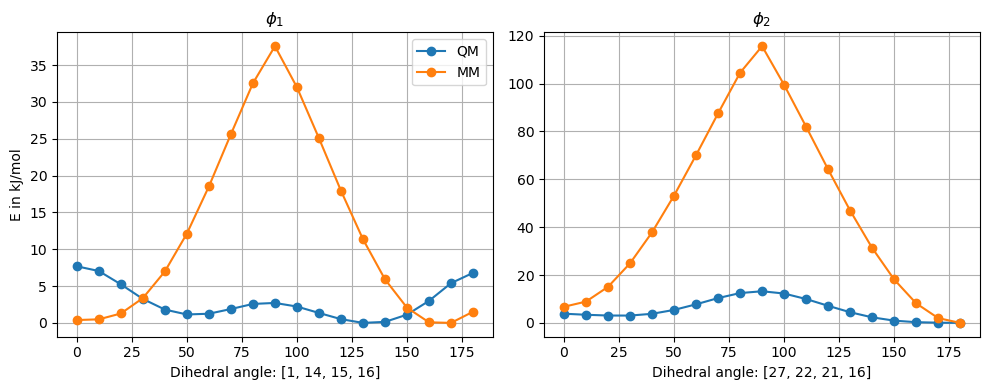

In [36]:
def custom_plot(res1, title1, res2, title2):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.title(title1)
    plt.plot(res1["dihedral_angles"], res1["qm_scan_kJpermol"], "o-")
    plt.plot(res1["dihedral_angles"], res1["mm_scan_kJpermol"], "o-")
    plt.legend(("QM", "MM"))
    plt.ylabel("E in kJ/mol")
    plt.xlabel("Dihedral angle: {}".format((res1["dihedral_indices"])))
    plt.grid()
    plt.subplot(122)
    plt.title(title2)
    plt.plot(res2["dihedral_angles"], res2["qm_scan_kJpermol"], "o-")
    plt.plot(res2["dihedral_angles"], res2["mm_scan_kJpermol"], "o-")
    plt.xlabel("Dihedral angle: {}".format((res2["dihedral_indices"])))
    plt.grid()
    plt.tight_layout()
    return False

custom_plot(phi_results[0], r"$\phi_1$", phi_results[1], r"$\phi_2$")
plt.show()

The potential energy surfaces of the original force field is very poor, and we will now improve this by refitting to the QM results.

## Fitting to QM potential

Correct original GAFF force field by fitting to the (full) QM potential;

```python
target_top_file = original_top_file
for i in range(len(ff_gen.target_dihedrals)):
    target_top_file = ff_gen.dihedral_correction(target_top_file, i)

fitted_phi_results = []
for i in range(len(ff_gen.target_dihedrals)):
    result = ff_gen.validate_force_field(target_top_file, i)
    fitted_phi_results.append(result)
```

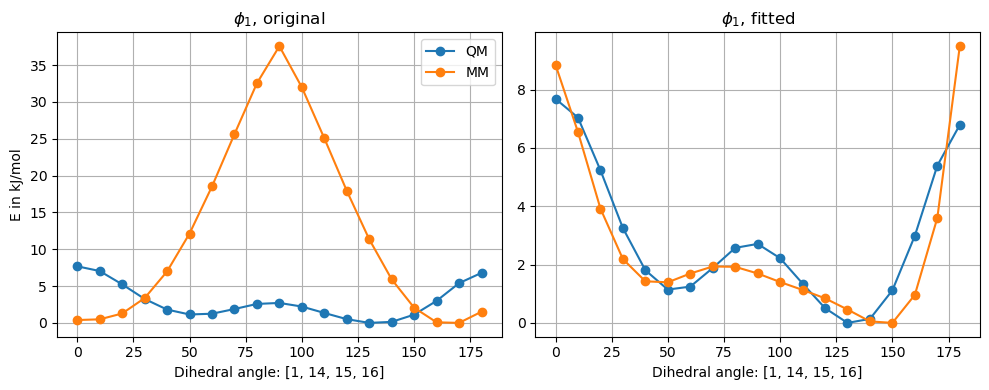

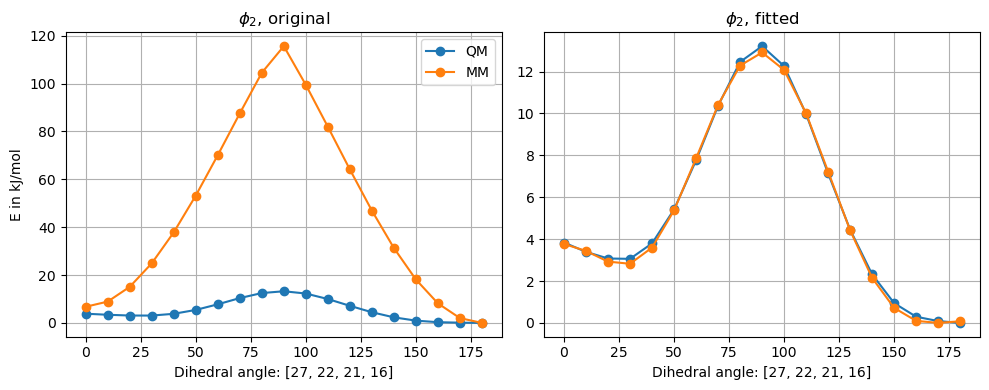

In [37]:
custom_plot(phi_results[0], r"$\phi_1$, original", fitted_phi_results[0], r"$\phi_1$, fitted")
custom_plot(phi_results[1], r"$\phi_2$, original", fitted_phi_results[1], r"$\phi_2$, fitted")
plt.show()

This leads to substantial improvement, but there are still some discrepancies, in particular for $\phi_1$. We will now consider two different improvements on this.

## Weighted fitting

```python
for i in range(len(ff_gen.target_dihedrals)):
    target_top_file = ff_gen.dihedral_correction(target_top_file, i, kT=10.0)

improved_phi_results = []
for i in range(len(ff_gen.target_dihedrals)):
    result = ff_gen.validate_force_field(target_top_file, i)
    improved_phi_results.append(result)
```

- Insert more theory, commeting how we fit with favour on low-energy regions which are typically thermally available
- Use same kT for both angles (check calculations)

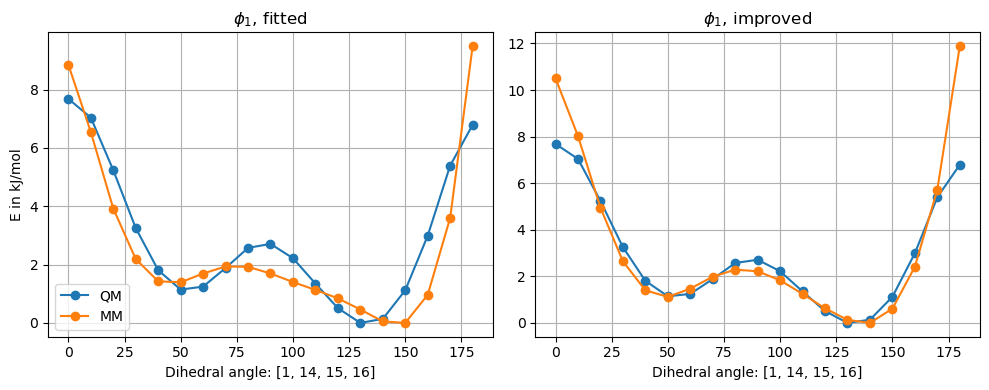

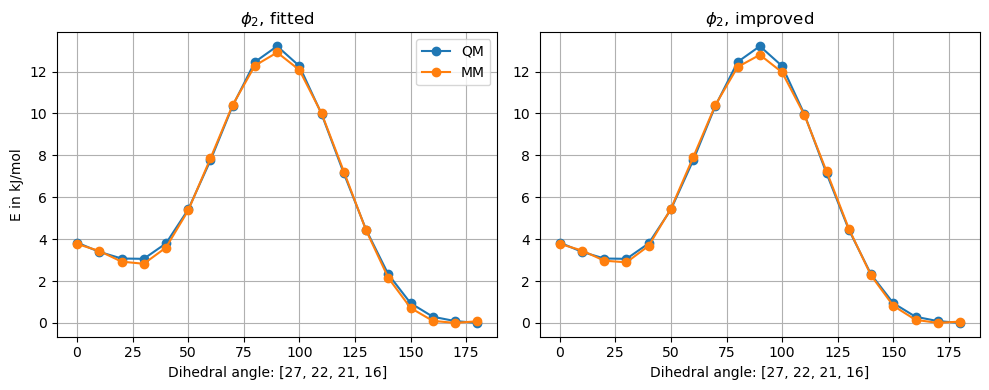

In [38]:
custom_plot(fitted_phi_results[0], r"$\phi_1$, fitted", improved_phi_results[0], r"$\phi_1$, improved")
custom_plot(fitted_phi_results[1], r"$\phi_2$, fitted", improved_phi_results[1], r"$\phi_2$, improved")
plt.show()

## Excluding tricky angles

- More theory

In [39]:
ff_gen.update_dihedral_range((20, 170), 0)
print(ff_gen.scan_dih_angles[0])

[20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0]


```python
for i in range(len(ff_gen.target_dihedrals)):
    target_top_file = ff_gen.dihedral_correction(target_top_file, i)

improved_phi_results_new = []
for i in range(len(ff_gen.target_dihedrals)):
    result = ff_gen.validate_force_field(target_top_file, i)
    improved_phi_results_new.append(result)
```

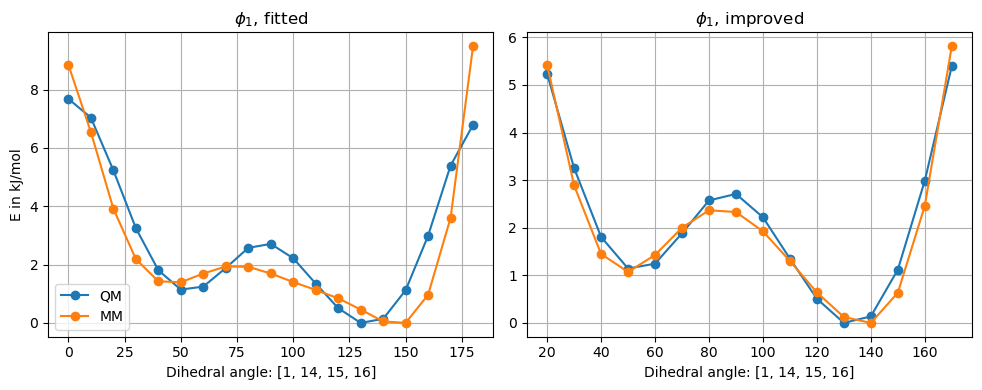

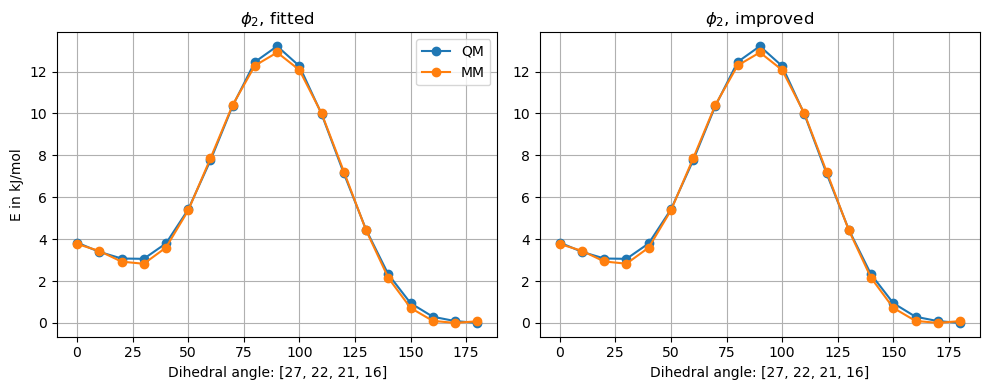

In [40]:
custom_plot(fitted_phi_results[0], r"$\phi_1$, fitted", improved_phi_results_new[0], r"$\phi_1$, improved")
custom_plot(fitted_phi_results[1], r"$\phi_2$, fitted", improved_phi_results_new[1], r"$\phi_2$, improved")
plt.show()